In [1]:
import numpy as np
import pandas as pd
import random
import math
import statistics
import matplotlib.pyplot as plt

In [2]:
reads = pd.read_csv('/Users/timothyliu/Documents/121/reads.tsv', sep='\t')#, index_col=0)
print(reads['observations'].unique())
print(reads)
#reads[reads['observations'] == 'A']

['A' 'T']
    observations  probability_of_error  error_truth
0              A              0.125650        False
1              T              0.092379        False
2              A              0.196982        False
3              T              0.063769        False
4              T              0.163563         True
..           ...                   ...          ...
995            A              0.037062        False
996            A              0.027094        False
997            A              0.146039        False
998            T              0.170114         True
999            T              0.038950        False

[1000 rows x 3 columns]


b) Write some code to estimate the posterior probability of the three possible genotypes
given the data

In [3]:
def prob_genotype_b(reads_input, genotype, num_observations):
    reads = reads_input.copy().sample(n=num_observations)
    
    '''
    P(G)
    '''
    log_prior_prob_AA = np.log(0.95*0.95)
    log_prior_prob_AT = np.log(0.095)
    log_prior_prob_TT = np.log(0.05*0.05)

    # Select the log prior based on genotype
    if genotype == 'AA':
        log_prior_prob = log_prior_prob_AA
    elif genotype == 'AT':
        log_prior_prob = log_prior_prob_AT
    elif genotype == 'TT':
        log_prior_prob = log_prior_prob_TT

    '''
    P(D | G)
    '''
    def prob_data_given_genotype(reads, genotype, num_observations):
        log_P_observationsGivenGenotype = 0
        
        for observation in range(num_observations):
            base = reads.iloc[observation]['observations']  # Get base of that observation
            error = reads.iloc[observation]['probability_of_error']  # Get error of that observation
            
            if base != genotype[0] and base != genotype[1]:  # If B | AA
                likelihood = error
            elif base == genotype[0] and base == genotype[1]:  # If A | AA
                likelihood = 1 - error
            else:  # If A | AB
                likelihood = 0.5
            
            log_P_observationsGivenGenotype += np.log(likelihood)

        return log_P_observationsGivenGenotype

    log_prob_dataGgenotype = prob_data_given_genotype(reads, genotype, num_observations)

    '''
    P(D)
    '''
    # Compute likelihoods for each genotype
    log_likelihood_AA = prob_data_given_genotype(reads, "AA", num_observations)
    log_likelihood_AT = prob_data_given_genotype(reads, "AT", num_observations)
    log_likelihood_TT = prob_data_given_genotype(reads, "TT", num_observations)

    # Log of total probability of data
    log_prob_data = np.logaddexp(np.logaddexp(log_likelihood_AA + log_prior_prob_AA, 
                                              log_likelihood_AT + log_prior_prob_AT), 
                                 log_likelihood_TT + log_prior_prob_TT)

    '''
    Putting it all together
    '''
    log_posterior = log_prob_dataGgenotype + log_prior_prob - log_prob_data
    posterior = np.exp(log_posterior)

    return posterior

# Assuming `reads` DataFrame is defined and available
# Example call
posterior_AA = prob_genotype_b(reads, "AA", 1000)
print("P(AA|D)=", posterior_AA)
posterior_AT = prob_genotype_b(reads, "AT", 1000)
print("P(AT|D)=", posterior_AT)
posterior_TT = prob_genotype_b(reads, "TT", 1000)
print("P(TT|D) =", posterior_TT)

P(AA|D)= 4.5662679273101534e-300
P(AT|D)= 1.0
P(TT|D) = 6.963414923136534e-290


c) Randomly sample 5 observations with replacement and re-estimate the posterior probability of each genotype. What are the results?

In [4]:
#P(G | D) = P(D | G) * P(G) / P(D)
def prob_genotype_c(reads_input, genotype, num_observations, random_seed=True):
    if random_seed:
        reads = reads_input.copy().sample(n=num_observations)
    else:
        reads = reads_input.copy().sample(n=num_observations, random_state=6)
    '''
    P(G)
    '''
    prior_prob_AA = 0.95*0.95
    prior_prob_AT = 0.095
    prior_prob_TT = 0.05*0.05

    if genotype == 'AA':
        prior_prob = prior_prob_AA
    elif genotype == 'AT':
        prior_prob = prior_prob_AT
    elif genotype == 'TT':
        prior_prob = prior_prob_TT

    #print("P(G):", prior_prob)
    '''
    P(D | G)
    '''

    def calc_prob_dataGgenotype(reads, genotype, num_observations):
        
        #Subsample of matrix
        
        
        '''
        Genotype: "AA", "AT", or "TT"
        Reads: Dataframe of reads
        Num_observations: Number of observations (from prev)
        '''
        
        P_observationsGivenGenotype = 1
        
        for observation in range(0, num_observations):
            base = reads.iloc[observation]['observations']  #Get base of that observation
            error = reads.iloc[observation]['probability_of_error'] #Get error of that observation
            #print(f"Observation {observation}: Base = {base}, Error = {error}")
            
            #B | AA or A | BB
            #Homozygous genotype
            if base != genotype[0] and base != genotype[1]: #If B | AA
                likelihood = error

            #B | BB or A | AA
            elif base == genotype[0] and base == genotype[1]: #If A | AA
                likelihood = 1 - error
                
            #B | AB or A | AB
            else:
                likelihood = 1/2
            P_observationsGivenGenotype *= likelihood
        return P_observationsGivenGenotype

    prob_dataGgenotype = calc_prob_dataGgenotype(reads, genotype, num_observations)
    #print("P(D | G):", prob_dataGgenotype)

    '''
    P(Data)
    '''

    #AA
    likelihood_AA = calc_prob_dataGgenotype(reads, "AA", num_observations)
    
    likelihood_AT = calc_prob_dataGgenotype(reads, "AT",num_observations)
    
    likelihood_TT = calc_prob_dataGgenotype(reads, "TT", num_observations)
    
    prob_data = ((likelihood_AA * prior_prob_AA) 
                 + (likelihood_AT * prior_prob_AT) 
                 + (likelihood_TT * prior_prob_TT))
    #print("P(Data):",prob_data)
        
    '''
    Putting it all together
    '''
    
    posterior = (prob_dataGgenotype * prior_prob) / prob_data
    #print("Posterior:",posterior)
    return posterior


posterior_AA = prob_genotype_c(reads, "AA", 5, random_seed=False)
print("P(AA|D)=",posterior_AA)
posterior_AT = prob_genotype_c(reads, "AT", 5, random_seed=False)
print("P(AT|D)=",posterior_AT)
posterior_TT = prob_genotype_c(reads, "TT", 5, random_seed=False)
print("P(TT|D) =",posterior_TT)

P(AA|D)= 0.0007040016426367364
P(AT|D)= 0.9790522220051942
P(TT|D) = 0.020243776352169073


d) Repeat (c) 1,000 times. That means you will have 1,000 estimates for each of your
posterior probabilities, each using 5 observations. This procedure is a variation of the
bootstrap. Make a histogram for each of the posterior probabilities. Please be mindful
of the number of bins and the appearance of your histogram. No one likes an ugly
histogram.

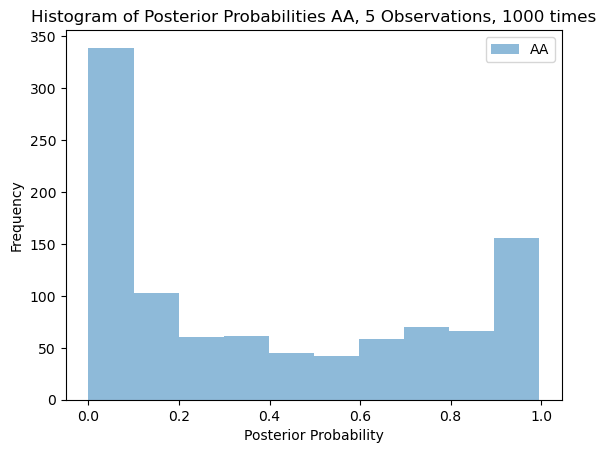

Mean: 0.3976534234101415, Standard Deviation: 0.36266924687145935


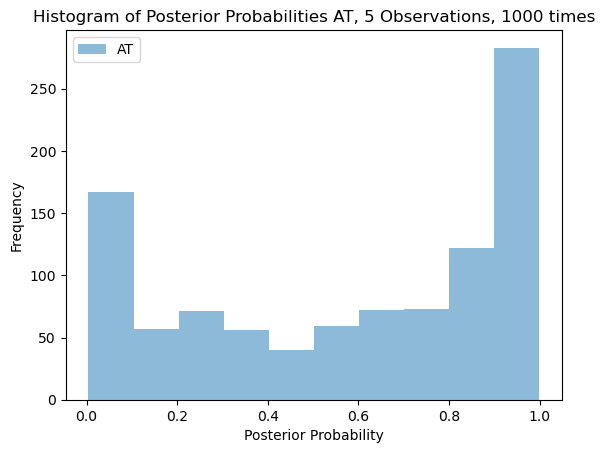

Mean: 0.5780704879226927, Standard Deviation: 0.34892567976833005


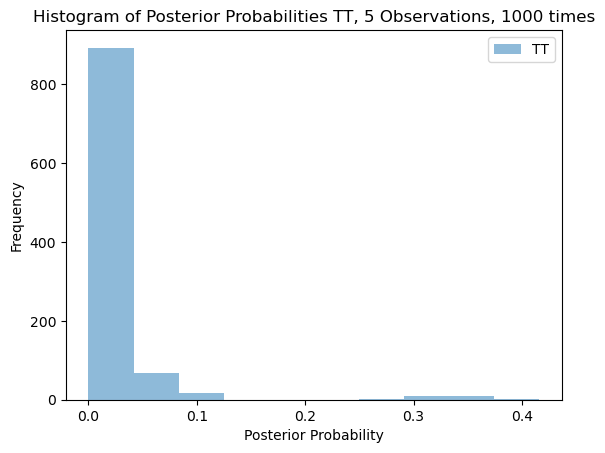

Mean: 0.01680041570704586, Standard Deviation: 0.05386400792756098


In [5]:
def make_histogram(list, title, label, bins=10):
    plt.hist(list, bins=bins, alpha=0.5, label=label)
    plt.xlabel('Posterior Probability')
    #plt.xlim(0,1)
    plt.ylabel('Frequency')
    plt.title(title)
    plt.legend()
    plt.show()

posterior_AA_list_5 = []
for i in range(0, 1000):
    posterior_AA_list_5.append(prob_genotype_c(reads, "AA",5))
make_histogram(posterior_AA_list_5, 'Histogram of Posterior Probabilities AA, 5 Observations, 1000 times', label="AA")
mean_AA_5 = statistics.mean(posterior_AA_list_5)
stdev_AA_5 = statistics.stdev(posterior_AA_list_5)
print(f"Mean: {mean_AA_5}, Standard Deviation: {stdev_AA_5}")

posterior_AT_list_5 = []
for i in range(0, 1000):
    posterior_AT_list_5.append(prob_genotype_c(reads, "AT", 5))
make_histogram(posterior_AT_list_5, 'Histogram of Posterior Probabilities AT, 5 Observations, 1000 times', label="AT")
mean_AT_5 = statistics.mean(posterior_AT_list_5)
stdev_AT_5 = statistics.stdev(posterior_AT_list_5)
print(f"Mean: {mean_AT_5}, Standard Deviation: {stdev_AT_5}")
    
posterior_TT_list_5 = []
for i in range(0, 1000):
    posterior_TT_list_5.append(prob_genotype_c(reads, "TT", 5))
make_histogram(posterior_TT_list_5, 'Histogram of Posterior Probabilities TT, 5 Observations, 1000 times', label="TT")
mean_TT_5 = statistics.mean(posterior_TT_list_5)
stdev_TT_5 = statistics.stdev(posterior_TT_list_5)
print(f"Mean: {mean_TT_5}, Standard Deviation: {stdev_TT_5}")

e) Repeat (d), but this time instead of taking 5 observations, take 50. Again, make three
histograms.

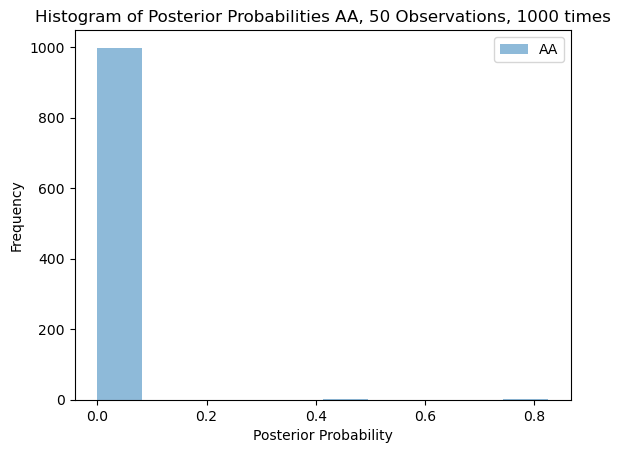

Mean: 0.0013459565004476288, Standard Deviation: 0.029880141213319496


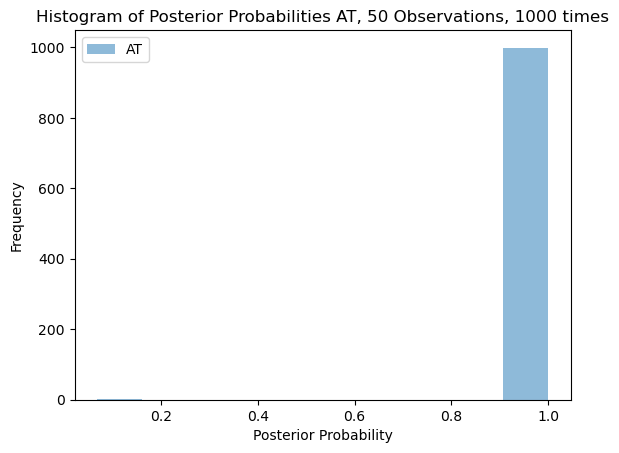

Mean: 0.9990643202691482, Standard Deviation: 0.029461578623106385


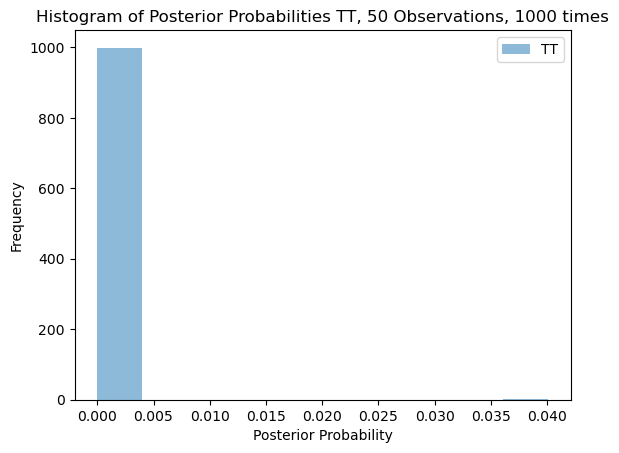

Mean: 4.0193286182381496e-05, Standard Deviation: 0.0012679733649842238


In [6]:
posterior_AA_list_50 = []
for i in range(0, 1000):
    posterior_AA_list_50.append(prob_genotype_c(reads, "AA", 50))
make_histogram(posterior_AA_list_50, 'Histogram of Posterior Probabilities AA, 50 Observations, 1000 times', label="AA")
mean_AA_50 = statistics.mean(posterior_AA_list_50)
stdev_AA_50 = statistics.stdev(posterior_AA_list_50)
print(f"Mean: {mean_AA_50}, Standard Deviation: {stdev_AA_50}")

posterior_AT_list_50 = []
for i in range(0, 1000):
    posterior_AT_list_50.append(prob_genotype_c(reads, "AT", 50))
make_histogram(posterior_AT_list_50, 'Histogram of Posterior Probabilities AT, 50 Observations, 1000 times', label="AT")
mean_AT_50 = statistics.mean(posterior_AT_list_50)
stdev_AT_50 = statistics.stdev(posterior_AT_list_50)
print(f"Mean: {mean_AT_50}, Standard Deviation: {stdev_AT_50}")
    
posterior_TT_list_50 = []
for i in range(0, 1000):
    posterior_TT_list_50.append(prob_genotype_c(reads, "TT", 50))
make_histogram(posterior_TT_list_50, 'Histogram of Posterior Probabilities TT, 50 Observations, 1000 times', label="TT")
mean_TT_50 = statistics.mean(posterior_TT_list_50)
stdev_TT_50 = statistics.stdev(posterior_TT_list_50)
print(f"Mean: {mean_TT_50}, Standard Deviation: {stdev_TT_50}")